<a href="https://colab.research.google.com/github/darengarciaH/AI-Question-Answering/blob/main/models/base_CTC_RNN_T_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jiwer editdistance --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import torch
import torchaudio
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from jiwer import wer, cer
import editdistance
import glob
from tqdm import tqdm
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split

In [4]:
from torch.cuda.amp import autocast, GradScaler
scaler_ctc = GradScaler()
scaler_rnnt = GradScaler()

<ipython-input-4-ae68ad2b3aa0>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_ctc = GradScaler()
<ipython-input-4-ae68ad2b3aa0>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_rnnt = GradScaler()


In [5]:
# Define vocabulary
vocab = list("abcdefghijklmnopqrstuvwxyz '") + ["|"]
char_to_index = {c: i for i, c in enumerate(vocab)}
index_to_char = {i: c for c, i in char_to_index.items()}


In [6]:
# Function to get the device
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Preprocessing Mel spectrograms
def preprocess_and_save_mel(root_dir, save_dir, sample_rate=16000, n_mels=80, use_gpu=False):
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels).to(device)
    resampler = torchaudio.transforms.Resample(orig_freq=48000, new_freq=sample_rate).to(device)

    # Step 1: Gather .wav files with tqdm
    print("Scanning for .wav files...")
    wav_paths = []
    for dirpath, _, filenames in tqdm(os.walk(root_dir), desc="Scanning folders"):
        for fname in filenames:
            if fname.endswith('.wav') and 'wav_headMic' in dirpath:
                wav_paths.append(os.path.join(dirpath, fname))

    print(f"Found {len(wav_paths)} .wav files. Starting preprocessing...")

    total_saved = 0

    # Step 2: Preprocess with tqdm
    for wav_path in tqdm(wav_paths, desc="Preprocessing Mel Spectrograms"):
        mel_path = os.path.join(save_dir, os.path.basename(wav_path).replace('.wav', '.pt'))
        txt_path = wav_path.replace('wav_headMic', 'prompts').replace('.wav', '.txt')

        if not os.path.exists(txt_path) or os.path.exists(mel_path):
            continue

        try:
            waveform, sr = torchaudio.load(wav_path)
            waveform = waveform.to(device)

            if sr != sample_rate:
                waveform = resampler(waveform)

            mel_spec = mel_transform(waveform).squeeze(0).transpose(0, 1).cpu()

            with open(txt_path, 'r', encoding='utf-8') as f:
                transcript = f.read().strip().lower()

            if '.jpg' in transcript or transcript in ('xxx', '') or '[say' in transcript:
                continue

            torch.save((mel_spec, transcript), mel_path)
            total_saved += 1
        except Exception as e:
            print(f"Error processing {wav_path}: {e}")

    print(f"\nDone: {total_saved} mel .pt files saved to {save_dir}")


In [8]:
'''
preprocess_and_save_mel(
    root_dir="/content/drive/MyDrive/TORGO",
    save_dir="/content/drive/MyDrive/TORGO_mel_preprocessed"
)
'''

'\npreprocess_and_save_mel(\n    root_dir="/content/drive/MyDrive/TORGO",\n    save_dir="/content/drive/MyDrive/TORGO_mel_preprocessed"\n)\n'

In [9]:
class TorgoDataset(Dataset):
    def __init__(self, root_dir, char_to_index, sample_rate=16000, items_file=None, use_precomputed=False, mel_dir=None):
        self.char_to_index = char_to_index
        self.sample_rate = sample_rate
        self.use_precomputed = use_precomputed
        self.items = []

        if self.use_precomputed:
            assert mel_dir is not None, "If using precomputed features, you must provide mel_dir."
            self.paths = sorted([
                os.path.join(mel_dir, f)
                for f in os.listdir(mel_dir) if f.endswith('.pt')
            ])
        else:
            self.mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=80)
            self.resampler = torchaudio.transforms.Resample(orig_freq=48000, new_freq=sample_rate)

            if items_file is not None:
                # Load cached wav+text metadata, then re-clean
                loaded_items = torch.load(items_file)
                for wav_fp, transcription_text in loaded_items:
                    transcription_text = transcription_text.strip().lower()
                    if '.jpg' in transcription_text or transcription_text in ('xxx', '') or '[say' in transcription_text:
                        continue
                    self.items.append((wav_fp, transcription_text))
            else:
                wav_files = []
                for dirpath, _, filenames in os.walk(root_dir):
                    for fname in filenames:
                        if fname.endswith('.wav') and 'wav_headMic' in dirpath:
                            wav_files.append(os.path.join(dirpath, fname))

                for wav_fp in tqdm(wav_files, desc=f"Building dataset from .wav files ({len(wav_files)} found)"):
                    txt_fp = wav_fp.replace('wav_headMic', 'prompts').replace('.wav', '.txt')
                    if not os.path.exists(txt_fp):
                        continue
                    with open(txt_fp, 'r', encoding='utf-8') as f:
                        transcription_text = f.read().strip().lower()
                    if '.jpg' in transcription_text or transcription_text in ('xxx', '') or '[say' in transcription_text:
                        continue
                    self.items.append((wav_fp, transcription_text))

    def __len__(self):
        return len(self.paths) if self.use_precomputed else len(self.items)

    def __getitem__(self, idx):
        if self.use_precomputed:
            mel_path = self.paths[idx]
            mel_spec, transcript = torch.load(mel_path)
        else:
            wav_path, transcript = self.items[idx]
            waveform, sr = torchaudio.load(wav_path)
            if sr != self.sample_rate:
                waveform = self.resampler(waveform)
            mel_spec = self.mel_transform(waveform).squeeze(0).transpose(0, 1)

        target = torch.tensor([self.char_to_index[c] for c in transcript if c in self.char_to_index])
        return mel_spec, target


In [10]:
# Batch collation for DataLoader: pad inputs and concatenate targets
def collate_fn(batch):
    # Filter out None samples
    batch = [sample for sample in batch if sample is not None]
    if len(batch) == 0:
        return None
    specs, targets = zip(*batch)
    spec_lens = torch.tensor([s.size(0) for s in specs], dtype=torch.long)
    target_lens = torch.tensor([t.size(0) for t in targets], dtype=torch.long)
    specs_padded = pad_sequence(specs, batch_first=True)
    targets_flat = torch.cat(targets)
    return specs_padded, targets_flat, spec_lens, target_lens


In [11]:
# Define the full RNN-T model with encoder, decoder, and joiner
class RNNTModel(nn.Module):
    def __init__(self, input_dim=80, vocab_size=len(vocab), hidden_dim=128, embed_dim=64):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.decoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.joiner = nn.Linear(hidden_dim * 3, vocab_size)

    def forward(self, encoder_input, target_input):
        enc_out, _ = self.encoder(encoder_input)
        dec_emb = self.embed(target_input)
        dec_out, _ = self.decoder(dec_emb)
        enc_exp = enc_out.unsqueeze(2)
        dec_exp = dec_out.unsqueeze(1)
        join = torch.cat([
            enc_exp.expand(-1, -1, dec_exp.size(2), -1),
            dec_exp.expand(-1, enc_exp.size(1), -1, -1)
        ], dim=-1)
        return self.joiner(join).squeeze(2)

In [12]:
# CTC Model Class
class CTCModel(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=128, vocab_size=len(vocab)):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        return self.fc(self.lstm(x)[0])

In [13]:
# Compute WER, CER, Edit Distance
def compute_wer_cer(preds, targets, target_lens):
    total_wer, total_cer, total_edit, offset = 0, 0, 0, 0
    for i, p in enumerate(preds):
        ref = targets[offset:offset + target_lens[i]].tolist()
        offset += target_lens[i]
        ref_str = ''.join(index_to_char[r] for r in ref)
        hyp_str = ''.join(index_to_char[x] for x in p if x in index_to_char)
        total_wer += wer(ref_str, hyp_str)
        total_cer += cer(ref_str, hyp_str)
        total_edit += editdistance.eval(ref_str, hyp_str)
    n = len(preds)
    return total_wer / n, total_cer / n, total_edit / n

In [14]:
from jiwer import cer

def decode_indices(indices, index_to_char):
    return ''.join([index_to_char[i] for i in indices if i in index_to_char]).replace('|', ' ').strip()

def compute_cer_accuracy(preds, targets, target_lens, index_to_char):
    offset = 0
    all_refs, all_hyps = [], []
    for i, tlen in enumerate(target_lens):
        ref = ''.join([index_to_char[x.item()] for x in targets[offset:offset + tlen]])
        hyp = ''.join([index_to_char[x] for x in preds[i]])
        all_refs.append(ref)
        all_hyps.append(hyp)
        offset += tlen
    return 1.0 - cer(all_refs, all_hyps)


In [15]:
# Greedy decoding for character prediction from model output
def greedy_decode(logits, input_lens, blank_index):
    pred = logits.argmax(dim=2)
    results = []
    for i in range(pred.size(0)):
        tokens, prev = [], None
        for j in range(input_lens[i]):
            idx = pred[i, j].item()
            if idx != blank_index and idx != prev:
                tokens.append(idx)
            prev = idx
        results.append(tokens)
    return results

In [28]:
def train_ctc(model, train_loader, val_loader, optimizer, loss_fn, blank_index, index_to_char,
              epochs=30, patience=5, device='cuda'):

    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        total_batches = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training (CTC)"):
            specs, targets_flat, input_lens, target_lens = batch
            if any(t < 2 for t in target_lens): continue

            specs, targets_flat = specs.to(device), targets_flat.to(device)
            input_lens, target_lens = input_lens.to(device), target_lens.to(device)

            optimizer.zero_grad()
            logits = model(specs)
            log_probs = F.log_softmax(logits, dim=2).transpose(0, 1)
            loss = loss_fn(log_probs, targets_flat, input_lens, target_lens)

            loss.backward()
            optimizer.step()

            preds = greedy_decode(logits, input_lens, blank_index)
            acc = compute_cer_accuracy(preds, targets_flat, target_lens, index_to_char)

            total_train_loss += loss.item()
            total_train_acc += acc
            total_batches += 1

        avg_train_loss = total_train_loss / total_batches
        avg_train_acc = total_train_acc / total_batches
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        total_val_batches = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation (CTC)"):
                specs, targets_flat, input_lens, target_lens = batch
                if any(t < 2 for t in target_lens): continue

                specs, targets_flat = specs.to(device), targets_flat.to(device)
                input_lens, target_lens = input_lens.to(device), target_lens.to(device)

                logits = model(specs)
                log_probs = F.log_softmax(logits, dim=2).transpose(0, 1)
                loss = loss_fn(log_probs, targets_flat, input_lens, target_lens)

                preds = greedy_decode(logits, input_lens, blank_index)
                acc = compute_cer_accuracy(preds, targets_flat, target_lens, index_to_char)

                total_val_loss += loss.item()
                total_val_acc += acc
                total_val_batches += 1

        avg_val_loss = total_val_loss / total_val_batches
        avg_val_acc = total_val_acc / total_val_batches
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | CER Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val CER Acc: {avg_val_acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⛔ Early stopping (CTC)")
                break

    return train_losses, train_accuracies, val_losses, val_accuracies


In [29]:
def train_rnnt(model, train_loader, val_loader, optimizer, loss_fn, blank_index, index_to_char,
               epochs=30, patience=5, device='cuda'):

    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        total_batches = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training (RNN-T)"):
            specs, targets_flat, input_lens, target_lens = batch
            if any(t < 2 for t in target_lens): continue

            specs, targets_flat = specs.to(device), targets_flat.to(device)
            input_lens, target_lens = input_lens.to(device), target_lens.to(device)

            batch_size = specs.size(0)
            target_max_len = target_lens.max().item()
            targets_in = torch.zeros((batch_size, target_max_len), dtype=torch.long, device=device)
            offset = 0
            for i in range(batch_size):
                l = target_lens[i].item()
                if l > 1:
                    targets_in[i, :l-1] = targets_flat[offset:offset+l-1]
                offset += l

            optimizer.zero_grad()
            logits = model(specs, targets_in)  # (B, T_enc, T_dec, V)
            mean_logits = logits.mean(dim=2)
            log_probs = F.log_softmax(mean_logits, dim=2).transpose(0, 1)
            loss = loss_fn(log_probs, targets_flat, input_lens, target_lens)

            loss.backward()
            optimizer.step()

            preds = greedy_decode(mean_logits, input_lens, blank_index)
            acc = compute_cer_accuracy(preds, targets_flat, target_lens, index_to_char)

            total_train_loss += loss.item()
            total_train_acc += acc
            total_batches += 1

        avg_train_loss = total_train_loss / total_batches
        avg_train_acc = total_train_acc / total_batches
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        total_val_batches = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation (RNN-T)"):
                specs, targets_flat, input_lens, target_lens = batch
                if any(t < 2 for t in target_lens): continue

                specs, targets_flat = specs.to(device), targets_flat.to(device)
                input_lens, target_lens = input_lens.to(device), target_lens.to(device)

                batch_size = specs.size(0)
                target_max_len = target_lens.max().item()
                targets_in = torch.zeros((batch_size, target_max_len), dtype=torch.long, device=device)
                offset = 0
                for i in range(batch_size):
                    l = target_lens[i].item()
                    if l > 1:
                        targets_in[i, :l-1] = targets_flat[offset:offset+l-1]
                    offset += l

                logits = model(specs, targets_in)
                mean_logits = logits.mean(dim=2)
                log_probs = F.log_softmax(mean_logits, dim=2).transpose(0, 1)
                loss = loss_fn(log_probs, targets_flat, input_lens, target_lens)

                preds = greedy_decode(mean_logits, input_lens, blank_index)
                acc = compute_cer_accuracy(preds, targets_flat, target_lens, index_to_char)

                total_val_loss += loss.item()
                total_val_acc += acc
                total_val_batches += 1

        avg_val_loss = total_val_loss / total_val_batches
        avg_val_acc = total_val_acc / total_val_batches
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | CER Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val CER Acc: {avg_val_acc:.4f}")

        if patience > 0 and avg_val_loss >= best_val_loss:
            patience_counter += 1
            if patience_counter >= patience:
                print("⛔ Early stopping (RNN-T)")
                break
        else:
            best_val_loss = avg_val_loss
            patience_counter = 0

    return train_losses, train_accuracies, val_losses, val_accuracies


In [42]:
def decode_indices(indices, index_to_char):
    return ''.join([index_to_char[i] for i in indices]).replace('|', ' ').strip()

def evaluate_and_plot_model(
    model,
    test_loader,
    loss_fn,
    blank_index,
    index_to_char,
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    model_name="Model",
    device='cuda'
    ):
    model.eval()
    model.to(device)

    total_loss = 0
    total_acc = 0
    total_batches = 0

    all_refs = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {model_name} on Test Set"):
            if batch is None:
                continue
            specs, targets_flat, input_lens, target_lens = batch
            specs, targets_flat = specs.to(device), targets_flat.to(device)
            input_lens, target_lens = input_lens.to(device), target_lens.to(device)

            # Check if the model is RNN-T and provide target input if necessary
            if model_name == "RNN-T":
                batch_size = specs.size(0)
                target_max_len = target_lens.max().item()
                targets_in = torch.zeros((batch_size, target_max_len), dtype=torch.long, device=device)
                offset = 0
                for i in range(batch_size):
                    l = target_lens[i].item()
                    if l > 1:
                        targets_in[i, :l - 1] = targets_flat[offset:offset + l - 1]
                    offset += l
                logits = model(specs, targets_in)  # Pass target input for RNN-T
                # Average the logits over the decoder time steps
                logits = logits.mean(dim=2)
            else:
                logits = model(specs)  # For CTC or other models

            log_probs = F.log_softmax(logits, dim=2).transpose(0, 1)
            loss = loss_fn(log_probs, targets_flat, input_lens, target_lens)

            preds = greedy_decode(logits, input_lens, blank_index)
            acc = compute_cer_accuracy(preds, targets_flat, target_lens, index_to_char)

            total_loss += loss.item()
            total_acc += acc
            total_batches += 1

            offset = 0
            for i, tlen in enumerate(target_lens):
                ref = decode_indices(targets_flat[offset:offset + tlen].tolist(), index_to_char)
                hyp = decode_indices(preds[i], index_to_char)
                all_refs.append(ref)
                all_preds.append(hyp)
                offset += tlen

    avg_loss = total_loss / total_batches
    avg_acc = total_acc / total_batches
    avg_wer = wer(all_refs, all_preds)
    avg_cer = cer(all_refs, all_preds)

    print(f"\n[{model_name} - Test Set]")
    print(f"Loss      : {avg_loss:.4f}")
    print(f"Char Acc  : {avg_acc:.4f}")
    print(f"WER       : {avg_wer:.4f}")
    print(f"CER       : {avg_cer:.4f}")

    # Plotting curves
    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(val_accuracies, label="Val Acc")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Char Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        "loss": avg_loss,
        "char_accuracy": avg_acc,
        "wer": avg_wer,
        "cer": avg_cer
    }


In [33]:
# Load data
data_dir = "/content/drive/MyDrive/TORGO"

# Load dataset
#dataset = TorgoDataset(data_dir, char_to_index)
#torch.save(dataset.items, '/content/drive/MyDrive/torgo_items.pt')
dataset = TorgoDataset(
    root_dir="/content/drive/MyDrive/TORGO",  # still required for structure
    char_to_index=char_to_index,
    use_precomputed=True,
    mel_dir="/content/drive/MyDrive/TORGO_mel_preprocessed"
)
print(f"Dataset length: {len(dataset)}")

# Calculate lengths
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len

# Perform split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True)



Dataset length: 993


In [34]:
# Train CTC model
model_ctc = CTCModel()
optimizer_ctc = torch.optim.Adam(model_ctc.parameters(), lr=1e-4)
loss_fn_ctc = nn.CTCLoss(blank=char_to_index['|'], zero_infinity=True)

ctc_train_loss, ctc_train_acc, ctc_val_loss, ctc_val_acc = train_ctc(
    model=model_ctc,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_ctc,
    loss_fn=loss_fn_ctc,
    blank_index=char_to_index['|'],
    index_to_char=index_to_char,
    epochs=30,
    patience=5,
    device='cuda'
)

Epoch 1 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 111.1384 | CER Acc: -1.8275 | Val Loss: 103.1696 | Val CER Acc: -2.0735


Epoch 2 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 109.0760 | CER Acc: -3.1638 | Val Loss: 100.7221 | Val CER Acc: -2.3592


Epoch 3 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 107.5710 | CER Acc: -0.9436 | Val Loss: 97.6454 | Val CER Acc: -0.1405


Epoch 4 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 102.6346 | CER Acc: -0.0756 | Val Loss: 93.7152 | Val CER Acc: 0.0467


Epoch 5 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 99.5593 | CER Acc: 0.0600 | Val Loss: 88.3262 | Val CER Acc: 0.1050


Epoch 6 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 91.6857 | CER Acc: 0.0764 | Val Loss: 80.7368 | Val CER Acc: 0.0631


Epoch 7 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 82.7617 | CER Acc: 0.0287 | Val Loss: 68.6601 | Val CER Acc: 0.0062


Epoch 8 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 8] Train Loss: 65.7592 | CER Acc: 0.0034 | Val Loss: 45.5204 | Val CER Acc: 0.0000


Epoch 9 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 9] Train Loss: 34.6042 | CER Acc: 0.0002 | Val Loss: 16.5716 | Val CER Acc: 0.0000


Epoch 10 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 10] Train Loss: 11.5748 | CER Acc: 0.0000 | Val Loss: 6.5269 | Val CER Acc: 0.0000


Epoch 11 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 11] Train Loss: 5.7417 | CER Acc: 0.0000 | Val Loss: 4.6740 | Val CER Acc: 0.0000


Epoch 12 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 12] Train Loss: 4.4951 | CER Acc: 0.0000 | Val Loss: 4.1545 | Val CER Acc: 0.0000


Epoch 13 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 13] Train Loss: 4.0985 | CER Acc: 0.0000 | Val Loss: 3.9525 | Val CER Acc: 0.0000


Epoch 14 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 14] Train Loss: 3.9191 | CER Acc: 0.0000 | Val Loss: 3.8540 | Val CER Acc: 0.0000


Epoch 15 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 15] Train Loss: 3.8386 | CER Acc: 0.0000 | Val Loss: 3.7968 | Val CER Acc: 0.0000


Epoch 16 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 16] Train Loss: 3.7753 | CER Acc: 0.0000 | Val Loss: 3.7595 | Val CER Acc: 0.0000


Epoch 17 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 17] Train Loss: 3.7417 | CER Acc: 0.0000 | Val Loss: 3.7327 | Val CER Acc: 0.0000


Epoch 18 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 18] Train Loss: 3.7135 | CER Acc: 0.0000 | Val Loss: 3.7118 | Val CER Acc: 0.0000


Epoch 19 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 19] Train Loss: 3.6853 | CER Acc: 0.0000 | Val Loss: 3.6948 | Val CER Acc: 0.0000


Epoch 20 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 20] Train Loss: 3.6650 | CER Acc: 0.0000 | Val Loss: 3.6802 | Val CER Acc: 0.0000


Epoch 21 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 21] Train Loss: 3.6404 | CER Acc: 0.0000 | Val Loss: 3.6669 | Val CER Acc: 0.0000


Epoch 22 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 22] Train Loss: 3.6313 | CER Acc: 0.0000 | Val Loss: 3.6546 | Val CER Acc: 0.0000


Epoch 23 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 23] Train Loss: 3.6188 | CER Acc: 0.0000 | Val Loss: 3.6433 | Val CER Acc: 0.0000


Epoch 24 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 24] Train Loss: 3.6022 | CER Acc: 0.0000 | Val Loss: 3.6328 | Val CER Acc: 0.0000


Epoch 25 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 25] Train Loss: 3.5940 | CER Acc: 0.0000 | Val Loss: 3.6225 | Val CER Acc: 0.0000


Epoch 26 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 26] Train Loss: 3.5746 | CER Acc: 0.0000 | Val Loss: 3.6126 | Val CER Acc: 0.0000


Epoch 27 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 27] Train Loss: 3.5613 | CER Acc: 0.0000 | Val Loss: 3.6030 | Val CER Acc: 0.0000


Epoch 28 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 28] Train Loss: 3.5508 | CER Acc: 0.0000 | Val Loss: 3.5937 | Val CER Acc: 0.0000


Epoch 29 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 29] Train Loss: 3.5426 | CER Acc: 0.0000 | Val Loss: 3.5847 | Val CER Acc: 0.0000


Epoch 30 - Training (CTC):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 - Validation (CTC):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 30] Train Loss: 3.5324 | CER Acc: 0.0000 | Val Loss: 3.5764 | Val CER Acc: 0.0000


In [35]:
# Train RNN-T model
model_rnnt = RNNTModel()
optimizer_rnnt = torch.optim.Adam(model_rnnt.parameters(), lr=1e-4)
loss_fn_rnnt = nn.CTCLoss(blank=char_to_index['|'], zero_infinity=True)

rnnt_train_loss, rnnt_train_acc, rnnt_val_loss, rnnt_val_acc = train_rnnt(
    model=model_rnnt,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_rnnt,
    loss_fn=loss_fn_rnnt,
    index_to_char=index_to_char,
    blank_index=char_to_index['|'],
    epochs=30,
    patience=5,
    device='cuda'
)

Epoch 1 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 109.9888 | CER Acc: -2.5984 | Val Loss: 99.3040 | Val CER Acc: -0.7591


Epoch 2 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 102.1591 | CER Acc: -0.2020 | Val Loss: 91.3290 | Val CER Acc: 0.1119


Epoch 3 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 92.9341 | CER Acc: 0.0845 | Val Loss: 81.6966 | Val CER Acc: 0.0563


Epoch 4 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 82.7611 | CER Acc: 0.0254 | Val Loss: 70.3108 | Val CER Acc: 0.0162


Epoch 5 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 69.5049 | CER Acc: 0.0054 | Val Loss: 56.9155 | Val CER Acc: 0.0029


Epoch 6 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 54.2868 | CER Acc: 0.0009 | Val Loss: 41.7512 | Val CER Acc: 0.0006


Epoch 7 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 37.9717 | CER Acc: 0.0001 | Val Loss: 25.9913 | Val CER Acc: 0.0000


Epoch 8 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 8] Train Loss: 21.1277 | CER Acc: 0.0000 | Val Loss: 11.5330 | Val CER Acc: 0.0000


Epoch 9 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 9] Train Loss: 7.7842 | CER Acc: 0.0000 | Val Loss: 4.1590 | Val CER Acc: 0.0000


Epoch 10 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 10] Train Loss: 3.7902 | CER Acc: 0.0000 | Val Loss: 3.6614 | Val CER Acc: 0.0000


Epoch 11 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 11] Train Loss: 3.6207 | CER Acc: 0.0000 | Val Loss: 3.6884 | Val CER Acc: 0.0000


Epoch 12 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 12] Train Loss: 3.6448 | CER Acc: 0.0000 | Val Loss: 3.6869 | Val CER Acc: 0.0000


Epoch 13 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 13] Train Loss: 3.6276 | CER Acc: 0.0000 | Val Loss: 3.6600 | Val CER Acc: 0.0000


Epoch 14 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 14] Train Loss: 3.6017 | CER Acc: 0.0000 | Val Loss: 3.6274 | Val CER Acc: 0.0000


Epoch 15 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 15] Train Loss: 3.5698 | CER Acc: 0.0000 | Val Loss: 3.5977 | Val CER Acc: 0.0000


Epoch 16 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 16] Train Loss: 3.5446 | CER Acc: 0.0000 | Val Loss: 3.5731 | Val CER Acc: 0.0000


Epoch 17 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 17] Train Loss: 3.5188 | CER Acc: 0.0000 | Val Loss: 3.5533 | Val CER Acc: 0.0000


Epoch 18 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 18] Train Loss: 3.5076 | CER Acc: 0.0000 | Val Loss: 3.5367 | Val CER Acc: 0.0000


Epoch 19 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 19] Train Loss: 3.4848 | CER Acc: 0.0000 | Val Loss: 3.5225 | Val CER Acc: 0.0000


Epoch 20 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 20] Train Loss: 3.4780 | CER Acc: 0.0000 | Val Loss: 3.5097 | Val CER Acc: 0.0000


Epoch 21 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 21] Train Loss: 3.4666 | CER Acc: 0.0000 | Val Loss: 3.4981 | Val CER Acc: 0.0000


Epoch 22 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 22] Train Loss: 3.4510 | CER Acc: 0.0000 | Val Loss: 3.4873 | Val CER Acc: 0.0000


Epoch 23 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 23] Train Loss: 3.4482 | CER Acc: 0.0000 | Val Loss: 3.4775 | Val CER Acc: 0.0000


Epoch 24 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 24] Train Loss: 3.4347 | CER Acc: 0.0000 | Val Loss: 3.4686 | Val CER Acc: 0.0000


Epoch 25 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 25] Train Loss: 3.4368 | CER Acc: 0.0000 | Val Loss: 3.4603 | Val CER Acc: 0.0000


Epoch 26 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 26] Train Loss: 3.4167 | CER Acc: 0.0000 | Val Loss: 3.4525 | Val CER Acc: 0.0000


Epoch 27 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 27] Train Loss: 3.4074 | CER Acc: 0.0000 | Val Loss: 3.4452 | Val CER Acc: 0.0000


Epoch 28 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 28] Train Loss: 3.4082 | CER Acc: 0.0000 | Val Loss: 3.4385 | Val CER Acc: 0.0000


Epoch 29 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 29] Train Loss: 3.4029 | CER Acc: 0.0000 | Val Loss: 3.4319 | Val CER Acc: 0.0000


Epoch 30 - Training (RNN-T):   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 - Validation (RNN-T):   0%|          | 0/2 [00:00<?, ?it/s]

[Epoch 30] Train Loss: 3.3952 | CER Acc: 0.0000 | Val Loss: 3.4261 | Val CER Acc: 0.0000


Evaluating CTC on Test Set:   0%|          | 0/4 [00:00<?, ?it/s]


[CTC - Test Set]
Loss      : 3.5470
Char Acc  : 0.0000
WER       : 1.0000
CER       : 1.0000


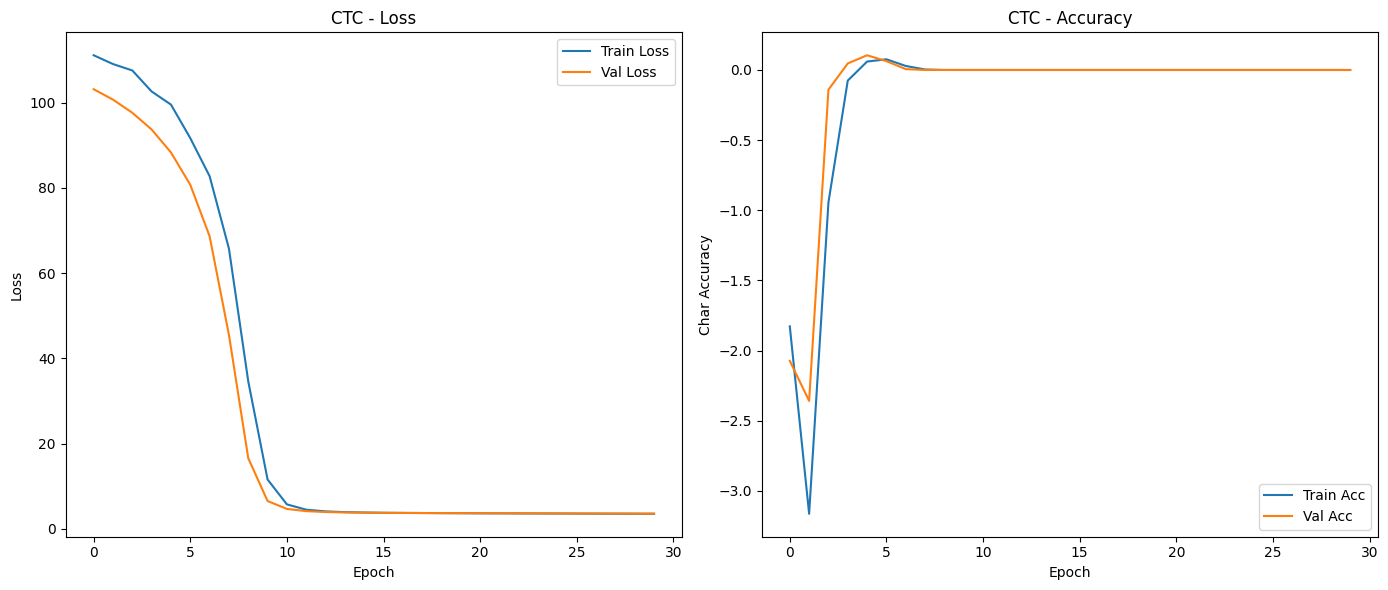

In [38]:
ctc_results = evaluate_and_plot_model(
    model=model_ctc,
    test_loader=test_loader,
    loss_fn=loss_fn_ctc,
    blank_index=char_to_index['|'],
    index_to_char=index_to_char,
    train_losses=ctc_train_loss,
    val_losses=ctc_val_loss,
    train_accuracies=ctc_train_acc,
    val_accuracies=ctc_val_acc,
    model_name="CTC",
    device='cuda'
)

Evaluating RNN-T on Test Set:   0%|          | 0/4 [00:00<?, ?it/s]


[RNN-T - Test Set]
Loss      : 4.3588
Char Acc  : 0.0000
WER       : 1.0000
CER       : 1.0000


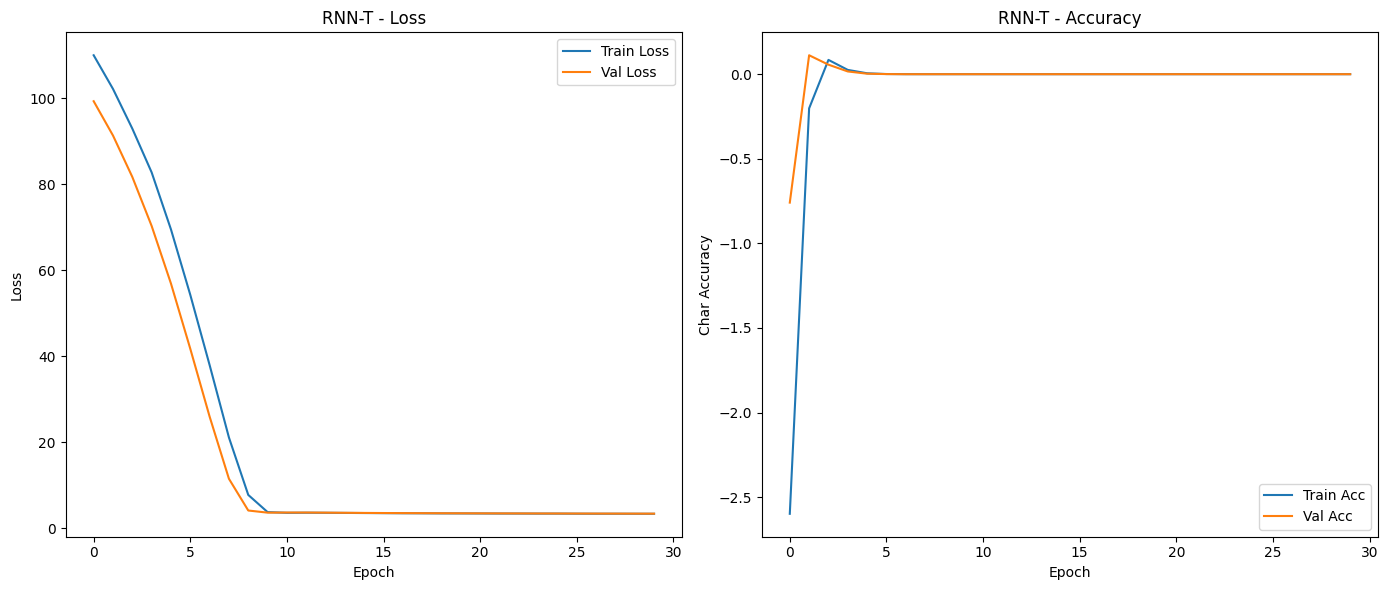

In [43]:
rnnt_results = evaluate_and_plot_model(
    model=model_rnnt,
    test_loader=test_loader,
    loss_fn=loss_fn_rnnt,
    blank_index=char_to_index['|'],
    index_to_char=index_to_char,
    train_losses=rnnt_train_loss,
    val_losses=rnnt_val_loss,
    train_accuracies=rnnt_train_acc,
    val_accuracies=rnnt_val_acc,
    model_name="RNN-T",
    device='cuda'
)